# Neural Networks - how to get a decent architecture?

## _Important_ if you let this run on Colab switch on the GPU option, because otherwise this part will take quite some time

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd
print(pd.__version__)

0.23.3


In [4]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.9.0


In [5]:
# let's see what compute devices we have available, hopefully a GPU 
sess = tf.Session()
devices = sess.list_devices()
for d in devices:
    print(d.name)

/job:localhost/replica:0/task:0/device:CPU:0
/job:localhost/replica:0/task:0/device:GPU:0


In [6]:
# a small sane check, does tf seem to work ok?
hello = tf.constant('Hello TF!')
print(sess.run(hello))

b'Hello TF!'


## Loading and preparing our data set for classification

In [7]:
!curl -O https://raw.githubusercontent.com/DJCordhose/ai/master/notebooks/manning/data/insurance-customers-1500.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 26798  100 26798    0     0  29065      0 --:--:-- --:--:-- --:--:-- 29065


In [8]:
df = pd.read_csv('./insurance-customers-1500.csv', sep=';')

In [9]:
df.head()

,max speed,age,thousand km per year,group
0,98.0,44.0,25.0,1
1,118.0,54.0,24.0,1
2,111.0,26.0,34.0,0
3,97.0,25.0,10.0,2
4,114.0,38.0,22.0,1


## First important concept: You train a machine with your data to make it learn the relationship between some input data and a certain label - this is called supervised learning

In [10]:
# we deliberately decide this is going to be our label, it is often called lower case y
y=df['group']

In [11]:
# since 'group' is now the label we want to predict, we need to remove it from the training data 
df.drop('group', axis='columns', inplace=True)

In [12]:
# input data often is named upper case X, the upper case indicates, that each row is a vector
X = df.as_matrix()

## Second important concept: To have an idea how well the training worked, we save same data to test our model on previously unseen data. 

* The real objective is to have a generalized model that works well on the test data.
* How well it performs on this test data as opposed to the training data tells us quite a bit as well.
* Typical splits are 60% for training and 40% for testing or 80/20
* It is important that we do not use the test data to tweak the hyper parameters of our learning strategy - in this case the test data would (indirectly) influence the training and can no longer tell how well we did
* evaluate the test date set only once at the end of your experiment

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
# using stratify we get a balanced number of samples per category (important!)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [15]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((900, 3), (900,), (600, 3), (600,))

In [16]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2], dtype=int64), array([301, 300, 299], dtype=int64))

In [17]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2], dtype=int64), array([200, 200, 200], dtype=int64))

In [18]:
# ignore this, it is just technical code to plot decision boundaries
# Adapted from:
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# http://jponttuset.cat/xkcd-deep-learning/

from matplotlib.colors import ListedColormap

cmap_print = ListedColormap(['#AA8888', '#004000', '#FFFFDD'])
cmap_bold = ListedColormap(['#AA4444', '#006000', '#EEEE44'])
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#FFFFDD'])
font_size=25
title_font_size=40

def meshGrid(x_data, y_data):
    h = 1  # step size in the mesh
    x_min, x_max = x_data.min() - 1, x_data.max() + 1
    y_min, y_max = y_data.min() - 1, y_data.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return (xx,yy)
    
def plot_prediction(clf, x_data, y_data, x_label, y_label, ground_truth, title="", 
                          mesh=True, fixed=None, fname=None, print=False):
    xx,yy = meshGrid(x_data, y_data)
    fig, ax = plt.subplots(figsize=(20,10))

    if clf and mesh:
        grid_X = np.array(np.c_[yy.ravel(), xx.ravel()])
        if fixed:
            fill_values = np.full((len(grid_X), 1), fixed)
            grid_X = np.append(grid_X, fill_values, axis=1)
        Z = clf.predict(grid_X)
        Z = np.argmax(Z, axis=1)
        Z = Z.reshape(xx.shape)
        ax.pcolormesh(xx, yy, Z, cmap=cmap_light)
        
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    if print:
        ax.scatter(x_data, y_data, c=ground_truth, cmap=cmap_print, s=200, marker='o', edgecolors='k')
    else:
        ax.scatter(x_data, y_data, c=ground_truth, cmap=cmap_bold, s=100, marker='o', edgecolors='k')
        
    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)
    ax.set_title(title, fontsize=title_font_size)
    if fname:
        fig.savefig('figures/'+fname)

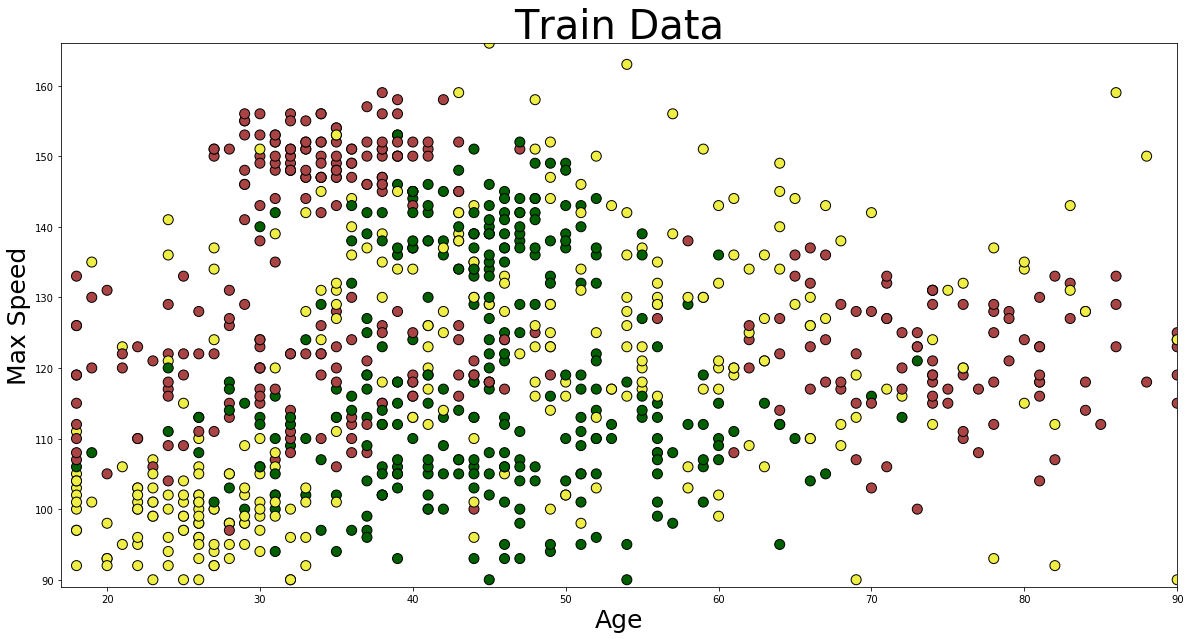

In [20]:
plot_prediction(None, X_train[:, 1], X_train[:, 0], 
               'Age', 'Max Speed', y_train, mesh=False,
                title="Train Data")

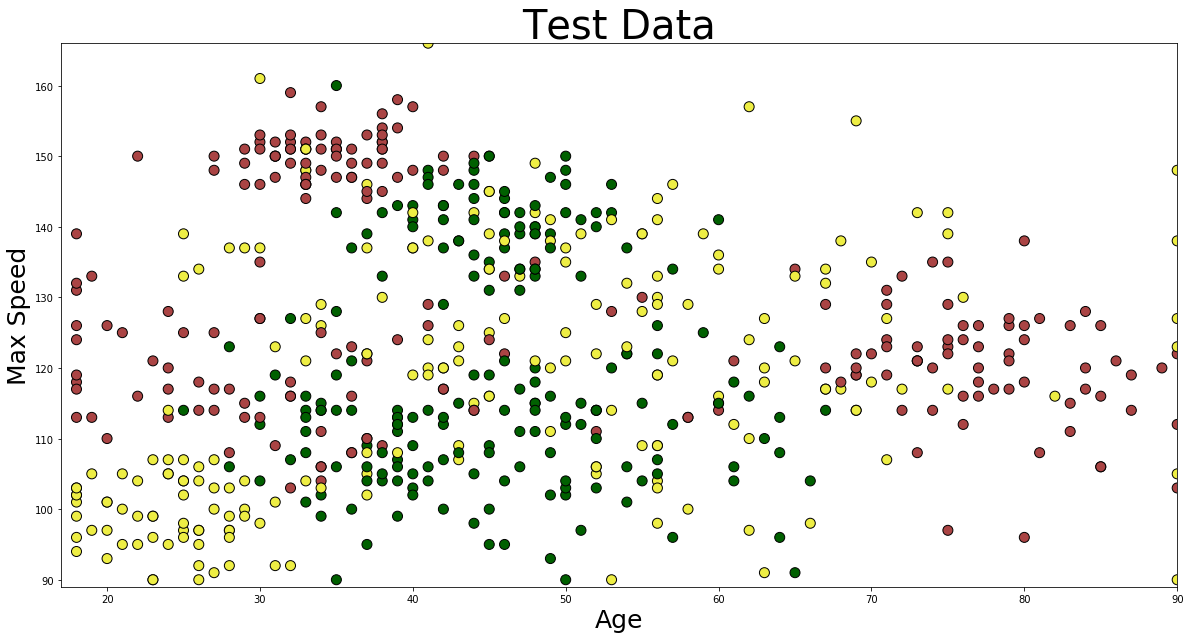

In [21]:
plot_prediction(None, X_test[:, 1], X_test[:, 0], 
               'Age', 'Max Speed', y_test, mesh=False,
                title="Test Data")

## Neural Networks using TensorFlow and Keras Layers
* Neural Networks consist of artificial neurons you organize in layers
* each neuron is very simple, but, theoretically, having enough of them in a single layer can approximate any funtion
* practically, we use 2 or 3 layers, as this has turned out to work well
* the more neurons and the more layers you use the longer the network takes to train
* neural networks often are no longer approachable using cross validation and grid search to find suitable hyper parameters

## Neuron (aka node or unit)

A neuron takes a number of numerical inputs, multiplies each with a weight, sums up all weighted input and adds bias (constant) to that sum. From this it creates a single numerical output. For one input (one dimension) this would be a description of a line. For more dimensions this describes a hyper plane that can serve as a decision boundary. Typically, this output is transformed using an activation function which compresses the output to a value between 0 and 1 (sigmoid), or between -1 and 1 (tanh) or sets all negative values to zero (relu).

It is not really important to understand the details of a neural network. Practically how you configure them to form something more powerful is much more important. This, however, is still a very experimental domain, so there really is no conscise explanation and understanding how they work.


### For now, we restrict the input to the two dimensions seen before to be able to plot decision boudaries

In [26]:
X_train_2_dim = X_train[:, :2]
X_test_2_dim = X_test[:, :2]

num_categories = 3

### We use a sequential mode, that means data flows without junctions from in to out

In [27]:
model = tf.keras.Sequential()

### We start with two layers each having 500 neurons, this should be more than enough capacity

In [28]:
model.add(tf.keras.layers.Dense(500, name='hidden1', activation='tanh', input_dim=2))
model.add(tf.keras.layers.Dense(500, name='hidden2', activation='tanh'))

### The final layer just transforms to likelyhood for each of our 3 classes

In [29]:
model.add(tf.keras.layers.Dense(num_categories, name='classifier', activation='softmax'))

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 500)               1500      
_________________________________________________________________
hidden2 (Dense)              (None, 500)               250500    
_________________________________________________________________
classifier (Dense)           (None, 3)                 1503      
Total params: 253,503
Trainable params: 253,503
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [32]:
# only if you are running this locally
!rm -rf ./tf_log
# https://keras.io/callbacks/#tensorboard
tb_callback = tf.keras.callbacks.TensorBoard(log_dir='./tf_log')
# To start tensorboard
# tensorboard --logdir=./tf_log
# open http://localhost:6006

In [33]:
BATCH_SIZE=1000
EPOCHS = 2000

%time model.fit(X_train_2_dim, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[tb_callback])

Train on 720 samples, validate on 180 samples
Epoch 1/2000
720/720 [==============================] - 0s 541us/step - loss: 1.4096 - acc: 0.3333 - val_loss: 2.9973 - val_acc: 0.3389
Epoch 2/2000
720/720 [==============================] - 0s 19us/step - loss: 3.0359 - acc: 0.3306 - val_loss: 2.9684 - val_acc: 0.3278
Epoch 3/2000
720/720 [==============================] - 0s 11us/step - loss: 2.9331 - acc: 0.3361 - val_loss: 1.6174 - val_acc: 0.3278
Epoch 4/2000
720/720 [==============================] - 0s 10us/step - loss: 1.5768 - acc: 0.3361 - val_loss: 1.2851 - val_acc: 0.3333
Epoch 5/2000
720/720 [==============================] - 0s 26us/step - loss: 1.2874 - acc: 0.3333 - val_loss: 1.8850 - val_acc: 0.3333
Epoch 6/2000
720/720 [==============================] - 0s 11us/step - loss: 1.9042 - acc: 0.3333 - val_loss: 1.7156 - val_acc: 0.3667
Epoch 7/2000
720/720 [==============================] - 0s 17us/step - loss: 1.7289 - acc: 0.4167 - val_loss: 1.5012 - val_acc: 0.3389
Epoch 8/

Epoch 61/2000
720/720 [==============================] - 0s 25us/step - loss: 0.8703 - acc: 0.6000 - val_loss: 0.9663 - val_acc: 0.5944
Epoch 62/2000
720/720 [==============================] - 0s 13us/step - loss: 0.8692 - acc: 0.6014 - val_loss: 0.9674 - val_acc: 0.5778
Epoch 63/2000
720/720 [==============================] - 0s 12us/step - loss: 0.8672 - acc: 0.6000 - val_loss: 0.9708 - val_acc: 0.5667
Epoch 64/2000
720/720 [==============================] - 0s 11us/step - loss: 0.8662 - acc: 0.6056 - val_loss: 0.9747 - val_acc: 0.5389
Epoch 65/2000
720/720 [==============================] - 0s 11us/step - loss: 0.8662 - acc: 0.6042 - val_loss: 0.9757 - val_acc: 0.5556
Epoch 66/2000
720/720 [==============================] - 0s 13us/step - loss: 0.8652 - acc: 0.6083 - val_loss: 0.9741 - val_acc: 0.5833
Epoch 67/2000
720/720 [==============================] - 0s 11us/step - loss: 0.8638 - acc: 0.6083 - val_loss: 0.9724 - val_acc: 0.5944
Epoch 68/2000
720/720 [=========================

Epoch 122/2000
720/720 [==============================] - 0s 26us/step - loss: 0.8307 - acc: 0.6583 - val_loss: 0.9370 - val_acc: 0.6111
Epoch 123/2000
720/720 [==============================] - 0s 6us/step - loss: 0.8302 - acc: 0.6583 - val_loss: 0.9364 - val_acc: 0.6111
Epoch 124/2000
720/720 [==============================] - 0s 0us/step - loss: 0.8298 - acc: 0.6583 - val_loss: 0.9361 - val_acc: 0.6111
Epoch 125/2000
720/720 [==============================] - 0s 11us/step - loss: 0.8293 - acc: 0.6583 - val_loss: 0.9357 - val_acc: 0.6111
Epoch 126/2000
720/720 [==============================] - 0s 13us/step - loss: 0.8288 - acc: 0.6583 - val_loss: 0.9350 - val_acc: 0.6111
Epoch 127/2000
720/720 [==============================] - 0s 11us/step - loss: 0.8284 - acc: 0.6569 - val_loss: 0.9344 - val_acc: 0.6111
Epoch 128/2000
720/720 [==============================] - 0s 19us/step - loss: 0.8279 - acc: 0.6597 - val_loss: 0.9339 - val_acc: 0.6111
Epoch 129/2000
720/720 [===================

Epoch 182/2000
720/720 [==============================] - 0s 14us/step - loss: 0.8095 - acc: 0.6639 - val_loss: 0.9124 - val_acc: 0.5778
Epoch 183/2000
720/720 [==============================] - 0s 0us/step - loss: 0.8142 - acc: 0.6444 - val_loss: 0.9182 - val_acc: 0.6389
Epoch 184/2000
720/720 [==============================] - 0s 16us/step - loss: 0.8228 - acc: 0.6528 - val_loss: 0.9191 - val_acc: 0.5611
Epoch 185/2000
720/720 [==============================] - 0s 10us/step - loss: 0.8210 - acc: 0.6264 - val_loss: 0.9102 - val_acc: 0.6278
Epoch 186/2000
720/720 [==============================] - 0s 10us/step - loss: 0.8129 - acc: 0.6625 - val_loss: 0.9023 - val_acc: 0.6389
Epoch 187/2000
720/720 [==============================] - 0s 11us/step - loss: 0.8046 - acc: 0.6681 - val_loss: 0.9058 - val_acc: 0.6000
Epoch 188/2000
720/720 [==============================] - 0s 22us/step - loss: 0.8088 - acc: 0.6542 - val_loss: 0.9117 - val_acc: 0.6389
Epoch 189/2000
720/720 [==================

Epoch 242/2000
720/720 [==============================] - 0s 7us/step - loss: 0.8007 - acc: 0.6625 - val_loss: 0.8869 - val_acc: 0.6167
Epoch 243/2000
720/720 [==============================] - 0s 24us/step - loss: 0.7946 - acc: 0.6569 - val_loss: 0.8825 - val_acc: 0.6556
Epoch 244/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7900 - acc: 0.6653 - val_loss: 0.8820 - val_acc: 0.6444
Epoch 245/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7904 - acc: 0.6681 - val_loss: 0.8839 - val_acc: 0.6278
Epoch 246/2000
720/720 [==============================] - 0s 13us/step - loss: 0.7937 - acc: 0.6583 - val_loss: 0.8865 - val_acc: 0.6333
Epoch 247/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7958 - acc: 0.6681 - val_loss: 0.8841 - val_acc: 0.6278
Epoch 248/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7931 - acc: 0.6611 - val_loss: 0.8814 - val_acc: 0.6500
Epoch 249/2000
720/720 [==================

Epoch 302/2000
720/720 [==============================] - 0s 26us/step - loss: 0.7816 - acc: 0.6667 - val_loss: 0.8709 - val_acc: 0.6333
Epoch 303/2000
720/720 [==============================] - 0s 25us/step - loss: 0.7821 - acc: 0.6722 - val_loss: 0.8680 - val_acc: 0.6500
Epoch 304/2000
720/720 [==============================] - 0s 15us/step - loss: 0.7803 - acc: 0.6694 - val_loss: 0.8654 - val_acc: 0.6556
Epoch 305/2000
720/720 [==============================] - 0s 24us/step - loss: 0.7784 - acc: 0.6778 - val_loss: 0.8667 - val_acc: 0.6556
Epoch 306/2000
720/720 [==============================] - 0s 26us/step - loss: 0.7782 - acc: 0.6806 - val_loss: 0.8681 - val_acc: 0.6500
Epoch 307/2000
720/720 [==============================] - 0s 29us/step - loss: 0.7792 - acc: 0.6736 - val_loss: 0.8667 - val_acc: 0.6389
Epoch 308/2000
720/720 [==============================] - 0s 29us/step - loss: 0.7799 - acc: 0.6750 - val_loss: 0.8675 - val_acc: 0.6500
Epoch 309/2000
720/720 [=================

Epoch 362/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7730 - acc: 0.6694 - val_loss: 0.8611 - val_acc: 0.6500
Epoch 363/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7733 - acc: 0.6694 - val_loss: 0.8591 - val_acc: 0.6333
Epoch 364/2000
720/720 [==============================] - 0s 10us/step - loss: 0.7736 - acc: 0.6694 - val_loss: 0.8625 - val_acc: 0.6556
Epoch 365/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7745 - acc: 0.6653 - val_loss: 0.8607 - val_acc: 0.6333
Epoch 366/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7754 - acc: 0.6639 - val_loss: 0.8660 - val_acc: 0.6556
Epoch 367/2000
720/720 [==============================] - 0s 10us/step - loss: 0.7774 - acc: 0.6625 - val_loss: 0.8639 - val_acc: 0.6056
Epoch 368/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7790 - acc: 0.6597 - val_loss: 0.8702 - val_acc: 0.6444
Epoch 369/2000
720/720 [=================

Epoch 422/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7627 - acc: 0.6750 - val_loss: 0.8497 - val_acc: 0.6556
Epoch 423/2000
720/720 [==============================] - 0s 10us/step - loss: 0.7625 - acc: 0.6806 - val_loss: 0.8496 - val_acc: 0.6556
Epoch 424/2000
720/720 [==============================] - 0s 10us/step - loss: 0.7624 - acc: 0.6778 - val_loss: 0.8497 - val_acc: 0.6500
Epoch 425/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7623 - acc: 0.6736 - val_loss: 0.8490 - val_acc: 0.6500
Epoch 426/2000
720/720 [==============================] - 0s 14us/step - loss: 0.7623 - acc: 0.6833 - val_loss: 0.8501 - val_acc: 0.6500
Epoch 427/2000
720/720 [==============================] - 0s 10us/step - loss: 0.7625 - acc: 0.6778 - val_loss: 0.8489 - val_acc: 0.6389
Epoch 428/2000
720/720 [==============================] - 0s 13us/step - loss: 0.7628 - acc: 0.6792 - val_loss: 0.8514 - val_acc: 0.6500
Epoch 429/2000
720/720 [=================

Epoch 482/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7569 - acc: 0.6736 - val_loss: 0.8438 - val_acc: 0.6500
Epoch 483/2000
720/720 [==============================] - 0s 13us/step - loss: 0.7570 - acc: 0.6819 - val_loss: 0.8449 - val_acc: 0.6556
Epoch 484/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7571 - acc: 0.6750 - val_loss: 0.8437 - val_acc: 0.6389
Epoch 485/2000
720/720 [==============================] - 0s 10us/step - loss: 0.7571 - acc: 0.6806 - val_loss: 0.8452 - val_acc: 0.6556
Epoch 486/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7572 - acc: 0.6778 - val_loss: 0.8434 - val_acc: 0.6333
Epoch 487/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7573 - acc: 0.6792 - val_loss: 0.8459 - val_acc: 0.6556
Epoch 488/2000
720/720 [==============================] - 0s 24us/step - loss: 0.7575 - acc: 0.6778 - val_loss: 0.8440 - val_acc: 0.6278
Epoch 489/2000
720/720 [=================

Epoch 542/2000
720/720 [==============================] - 0s 22us/step - loss: 0.7515 - acc: 0.6806 - val_loss: 0.8402 - val_acc: 0.6556
Epoch 543/2000
720/720 [==============================] - 0s 22us/step - loss: 0.7514 - acc: 0.6806 - val_loss: 0.8404 - val_acc: 0.6556
Epoch 544/2000
720/720 [==============================] - 0s 0us/step - loss: 0.7513 - acc: 0.6792 - val_loss: 0.8403 - val_acc: 0.6556
Epoch 545/2000
720/720 [==============================] - 0s 0us/step - loss: 0.7512 - acc: 0.6806 - val_loss: 0.8404 - val_acc: 0.6556
Epoch 546/2000
720/720 [==============================] - 0s 0us/step - loss: 0.7511 - acc: 0.6792 - val_loss: 0.8398 - val_acc: 0.6556
Epoch 547/2000
720/720 [==============================] - 0s 0us/step - loss: 0.7511 - acc: 0.6792 - val_loss: 0.8400 - val_acc: 0.6556
Epoch 548/2000
720/720 [==============================] - 0s 0us/step - loss: 0.7510 - acc: 0.6792 - val_loss: 0.8396 - val_acc: 0.6556
Epoch 549/2000
720/720 [======================

720/720 [==============================] - 0s 0us/step - loss: 0.7480 - acc: 0.6806 - val_loss: 0.8368 - val_acc: 0.6611
Epoch 603/2000
720/720 [==============================] - 0s 0us/step - loss: 0.7477 - acc: 0.6833 - val_loss: 0.8381 - val_acc: 0.6556
Epoch 604/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7476 - acc: 0.6819 - val_loss: 0.8416 - val_acc: 0.6556
Epoch 605/2000
720/720 [==============================] - 0s 0us/step - loss: 0.7478 - acc: 0.6764 - val_loss: 0.8377 - val_acc: 0.6611
Epoch 606/2000
720/720 [==============================] - 0s 0us/step - loss: 0.7473 - acc: 0.6833 - val_loss: 0.8363 - val_acc: 0.6611
Epoch 607/2000
720/720 [==============================] - 0s 0us/step - loss: 0.7472 - acc: 0.6847 - val_loss: 0.8388 - val_acc: 0.6556
Epoch 608/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7472 - acc: 0.6764 - val_loss: 0.8382 - val_acc: 0.6556
Epoch 609/2000
720/720 [==============================] - 0s 

Epoch 663/2000
720/720 [==============================] - 0s 15us/step - loss: 0.7427 - acc: 0.6847 - val_loss: 0.8359 - val_acc: 0.6556
Epoch 664/2000
720/720 [==============================] - 0s 26us/step - loss: 0.7426 - acc: 0.6833 - val_loss: 0.8355 - val_acc: 0.6611
Epoch 665/2000
720/720 [==============================] - 0s 14us/step - loss: 0.7426 - acc: 0.6861 - val_loss: 0.8361 - val_acc: 0.6556
Epoch 666/2000
720/720 [==============================] - 0s 14us/step - loss: 0.7425 - acc: 0.6847 - val_loss: 0.8352 - val_acc: 0.6611
Epoch 667/2000
720/720 [==============================] - 0s 22us/step - loss: 0.7425 - acc: 0.6847 - val_loss: 0.8361 - val_acc: 0.6556
Epoch 668/2000
720/720 [==============================] - 0s 26us/step - loss: 0.7424 - acc: 0.6861 - val_loss: 0.8351 - val_acc: 0.6556
Epoch 669/2000
720/720 [==============================] - 0s 12us/step - loss: 0.7424 - acc: 0.6819 - val_loss: 0.8367 - val_acc: 0.6556
Epoch 670/2000
720/720 [=================

Epoch 723/2000
720/720 [==============================] - 0s 0us/step - loss: 0.7392 - acc: 0.6819 - val_loss: 0.8338 - val_acc: 0.6611
Epoch 724/2000
720/720 [==============================] - 0s 22us/step - loss: 0.7389 - acc: 0.6889 - val_loss: 0.8341 - val_acc: 0.6611
Epoch 725/2000
720/720 [==============================] - 0s 22us/step - loss: 0.7387 - acc: 0.6847 - val_loss: 0.8341 - val_acc: 0.6611
Epoch 726/2000
720/720 [==============================] - 0s 22us/step - loss: 0.7386 - acc: 0.6847 - val_loss: 0.8334 - val_acc: 0.6611
Epoch 727/2000
720/720 [==============================] - 0s 22us/step - loss: 0.7386 - acc: 0.6889 - val_loss: 0.8352 - val_acc: 0.6556
Epoch 728/2000
720/720 [==============================] - 0s 24us/step - loss: 0.7387 - acc: 0.6875 - val_loss: 0.8338 - val_acc: 0.6611
Epoch 729/2000
720/720 [==============================] - 0s 13us/step - loss: 0.7386 - acc: 0.6875 - val_loss: 0.8353 - val_acc: 0.6556
Epoch 730/2000
720/720 [==================

Epoch 783/2000
720/720 [==============================] - 0s 0us/step - loss: 0.7381 - acc: 0.6778 - val_loss: 0.8371 - val_acc: 0.6556
Epoch 784/2000
720/720 [==============================] - 0s 0us/step - loss: 0.7361 - acc: 0.6917 - val_loss: 0.8338 - val_acc: 0.6611
Epoch 785/2000
720/720 [==============================] - 0s 22us/step - loss: 0.7347 - acc: 0.6875 - val_loss: 0.8328 - val_acc: 0.6444
Epoch 786/2000
720/720 [==============================] - 0s 22us/step - loss: 0.7356 - acc: 0.6847 - val_loss: 0.8396 - val_acc: 0.6556
Epoch 787/2000
720/720 [==============================] - 0s 22us/step - loss: 0.7368 - acc: 0.6917 - val_loss: 0.8340 - val_acc: 0.6444
Epoch 788/2000
720/720 [==============================] - 0s 22us/step - loss: 0.7364 - acc: 0.6833 - val_loss: 0.8350 - val_acc: 0.6556
Epoch 789/2000
720/720 [==============================] - 0s 0us/step - loss: 0.7350 - acc: 0.6875 - val_loss: 0.8333 - val_acc: 0.6556
Epoch 790/2000
720/720 [====================

Epoch 843/2000
720/720 [==============================] - 0s 43us/step - loss: 0.7412 - acc: 0.6792 - val_loss: 0.8333 - val_acc: 0.6500
Epoch 844/2000
720/720 [==============================] - 0s 33us/step - loss: 0.7373 - acc: 0.6736 - val_loss: 0.8353 - val_acc: 0.6500
Epoch 845/2000
720/720 [==============================] - 0s 29us/step - loss: 0.7320 - acc: 0.6889 - val_loss: 0.8343 - val_acc: 0.6556
Epoch 846/2000
720/720 [==============================] - 0s 36us/step - loss: 0.7305 - acc: 0.6917 - val_loss: 0.8325 - val_acc: 0.6444
Epoch 847/2000
720/720 [==============================] - 0s 25us/step - loss: 0.7331 - acc: 0.6875 - val_loss: 0.8434 - val_acc: 0.6500
Epoch 848/2000
720/720 [==============================] - 0s 29us/step - loss: 0.7357 - acc: 0.6861 - val_loss: 0.8336 - val_acc: 0.6444
Epoch 849/2000
720/720 [==============================] - 0s 25us/step - loss: 0.7347 - acc: 0.6792 - val_loss: 0.8344 - val_acc: 0.6500
Epoch 850/2000
720/720 [=================

Epoch 903/2000
720/720 [==============================] - 0s 13us/step - loss: 0.7259 - acc: 0.6917 - val_loss: 0.8364 - val_acc: 0.6500
Epoch 904/2000
720/720 [==============================] - 0s 0us/step - loss: 0.7281 - acc: 0.6917 - val_loss: 0.8306 - val_acc: 0.6444
Epoch 905/2000
720/720 [==============================] - 0s 6us/step - loss: 0.7312 - acc: 0.6847 - val_loss: 0.8434 - val_acc: 0.6444
Epoch 906/2000
720/720 [==============================] - 0s 0us/step - loss: 0.7327 - acc: 0.6861 - val_loss: 0.8298 - val_acc: 0.6444
Epoch 907/2000
720/720 [==============================] - 0s 0us/step - loss: 0.7308 - acc: 0.6847 - val_loss: 0.8349 - val_acc: 0.6500
Epoch 908/2000
720/720 [==============================] - 0s 0us/step - loss: 0.7277 - acc: 0.6903 - val_loss: 0.8298 - val_acc: 0.6556
Epoch 909/2000
720/720 [==============================] - 0s 22us/step - loss: 0.7256 - acc: 0.6958 - val_loss: 0.8286 - val_acc: 0.6611
Epoch 910/2000
720/720 [======================

Epoch 963/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7279 - acc: 0.6847 - val_loss: 0.8307 - val_acc: 0.6500
Epoch 964/2000
720/720 [==============================] - 0s 10us/step - loss: 0.7226 - acc: 0.6931 - val_loss: 0.8283 - val_acc: 0.6500
Epoch 965/2000
720/720 [==============================] - 0s 10us/step - loss: 0.7214 - acc: 0.6944 - val_loss: 0.8311 - val_acc: 0.6444
Epoch 966/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7246 - acc: 0.6889 - val_loss: 0.8384 - val_acc: 0.6500
Epoch 967/2000
720/720 [==============================] - 0s 10us/step - loss: 0.7259 - acc: 0.6889 - val_loss: 0.8294 - val_acc: 0.6444
Epoch 968/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7233 - acc: 0.6944 - val_loss: 0.8252 - val_acc: 0.6500
Epoch 969/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7208 - acc: 0.6972 - val_loss: 0.8289 - val_acc: 0.6500
Epoch 970/2000
720/720 [=================

Epoch 1023/2000
720/720 [==============================] - 0s 12us/step - loss: 0.7168 - acc: 0.6986 - val_loss: 0.8301 - val_acc: 0.6556
Epoch 1024/2000
720/720 [==============================] - 0s 13us/step - loss: 0.7169 - acc: 0.6931 - val_loss: 0.8214 - val_acc: 0.6444
Epoch 1025/2000
720/720 [==============================] - 0s 15us/step - loss: 0.7194 - acc: 0.6931 - val_loss: 0.8404 - val_acc: 0.6500
Epoch 1026/2000
720/720 [==============================] - 0s 14us/step - loss: 0.7268 - acc: 0.6806 - val_loss: 0.8376 - val_acc: 0.6444
Epoch 1027/2000
720/720 [==============================] - 0s 13us/step - loss: 0.7424 - acc: 0.6694 - val_loss: 0.8914 - val_acc: 0.6333
Epoch 1028/2000
720/720 [==============================] - 0s 12us/step - loss: 0.7696 - acc: 0.6750 - val_loss: 0.8729 - val_acc: 0.6000
Epoch 1029/2000
720/720 [==============================] - 0s 12us/step - loss: 0.7885 - acc: 0.6222 - val_loss: 0.9268 - val_acc: 0.6389
Epoch 1030/2000
720/720 [=========

Epoch 1083/2000
720/720 [==============================] - 0s 14us/step - loss: 0.7103 - acc: 0.7028 - val_loss: 0.8200 - val_acc: 0.6444
Epoch 1084/2000
720/720 [==============================] - 0s 12us/step - loss: 0.7104 - acc: 0.6986 - val_loss: 0.8182 - val_acc: 0.6500
Epoch 1085/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7100 - acc: 0.7028 - val_loss: 0.8195 - val_acc: 0.6500
Epoch 1086/2000
720/720 [==============================] - 0s 13us/step - loss: 0.7099 - acc: 0.7000 - val_loss: 0.8182 - val_acc: 0.6444
Epoch 1087/2000
720/720 [==============================] - 0s 13us/step - loss: 0.7099 - acc: 0.6986 - val_loss: 0.8187 - val_acc: 0.6500
Epoch 1088/2000
720/720 [==============================] - 0s 12us/step - loss: 0.7097 - acc: 0.7042 - val_loss: 0.8190 - val_acc: 0.6500
Epoch 1089/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7095 - acc: 0.7000 - val_loss: 0.8180 - val_acc: 0.6444
Epoch 1090/2000
720/720 [=========

Epoch 1143/2000
720/720 [==============================] - 0s 12us/step - loss: 0.7046 - acc: 0.7014 - val_loss: 0.8298 - val_acc: 0.6611
Epoch 1144/2000
720/720 [==============================] - 0s 12us/step - loss: 0.7099 - acc: 0.7000 - val_loss: 0.8133 - val_acc: 0.6389
Epoch 1145/2000
720/720 [==============================] - 0s 13us/step - loss: 0.7114 - acc: 0.6917 - val_loss: 0.8272 - val_acc: 0.6611
Epoch 1146/2000
720/720 [==============================] - 0s 13us/step - loss: 0.7080 - acc: 0.7028 - val_loss: 0.8151 - val_acc: 0.6500
Epoch 1147/2000
720/720 [==============================] - 0s 10us/step - loss: 0.7039 - acc: 0.7042 - val_loss: 0.8119 - val_acc: 0.6333
Epoch 1148/2000
720/720 [==============================] - 0s 13us/step - loss: 0.7059 - acc: 0.7014 - val_loss: 0.8296 - val_acc: 0.6611
Epoch 1149/2000
720/720 [==============================] - 0s 14us/step - loss: 0.7093 - acc: 0.7014 - val_loss: 0.8131 - val_acc: 0.6333
Epoch 1150/2000
720/720 [=========

Epoch 1203/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6991 - acc: 0.7042 - val_loss: 0.8056 - val_acc: 0.6333
Epoch 1204/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6998 - acc: 0.7042 - val_loss: 0.8209 - val_acc: 0.6611
Epoch 1205/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7017 - acc: 0.7042 - val_loss: 0.8061 - val_acc: 0.6389
Epoch 1206/2000
720/720 [==============================] - 0s 17us/step - loss: 0.7041 - acc: 0.6972 - val_loss: 0.8356 - val_acc: 0.6611
Epoch 1207/2000
720/720 [==============================] - 0s 15us/step - loss: 0.7105 - acc: 0.7028 - val_loss: 0.8118 - val_acc: 0.6500
Epoch 1208/2000
720/720 [==============================] - 0s 17us/step - loss: 0.7152 - acc: 0.6819 - val_loss: 0.8618 - val_acc: 0.6611
Epoch 1209/2000
720/720 [==============================] - 0s 15us/step - loss: 0.7298 - acc: 0.6944 - val_loss: 0.8200 - val_acc: 0.6389
Epoch 1210/2000
720/720 [=========

Epoch 1263/2000
720/720 [==============================] - 0s 14us/step - loss: 0.7010 - acc: 0.7028 - val_loss: 0.8108 - val_acc: 0.6500
Epoch 1264/2000
720/720 [==============================] - 0s 15us/step - loss: 0.6962 - acc: 0.7000 - val_loss: 0.8067 - val_acc: 0.6611
Epoch 1265/2000
720/720 [==============================] - 0s 17us/step - loss: 0.6927 - acc: 0.7097 - val_loss: 0.8090 - val_acc: 0.6667
Epoch 1266/2000
720/720 [==============================] - 0s 17us/step - loss: 0.6916 - acc: 0.7028 - val_loss: 0.8038 - val_acc: 0.6500
Epoch 1267/2000
720/720 [==============================] - 0s 22us/step - loss: 0.6931 - acc: 0.7056 - val_loss: 0.8132 - val_acc: 0.6667
Epoch 1268/2000
720/720 [==============================] - 0s 17us/step - loss: 0.6954 - acc: 0.7125 - val_loss: 0.8057 - val_acc: 0.6500
Epoch 1269/2000
720/720 [==============================] - 0s 14us/step - loss: 0.6963 - acc: 0.6944 - val_loss: 0.8127 - val_acc: 0.6611
Epoch 1270/2000
720/720 [=========

Epoch 1323/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6863 - acc: 0.7056 - val_loss: 0.8004 - val_acc: 0.6611
Epoch 1324/2000
720/720 [==============================] - 0s 13us/step - loss: 0.6859 - acc: 0.7139 - val_loss: 0.8027 - val_acc: 0.6611
Epoch 1325/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6855 - acc: 0.7069 - val_loss: 0.8016 - val_acc: 0.6611
Epoch 1326/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6852 - acc: 0.7125 - val_loss: 0.8023 - val_acc: 0.6611
Epoch 1327/2000
720/720 [==============================] - 0s 14us/step - loss: 0.6852 - acc: 0.7111 - val_loss: 0.8026 - val_acc: 0.6611
Epoch 1328/2000
720/720 [==============================] - 0s 15us/step - loss: 0.6852 - acc: 0.7083 - val_loss: 0.8007 - val_acc: 0.6611
Epoch 1329/2000
720/720 [==============================] - 0s 14us/step - loss: 0.6853 - acc: 0.7125 - val_loss: 0.8025 - val_acc: 0.6556
Epoch 1330/2000
720/720 [=========

Epoch 1383/2000
720/720 [==============================] - 0s 13us/step - loss: 0.6807 - acc: 0.7111 - val_loss: 0.7970 - val_acc: 0.6556
Epoch 1384/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6811 - acc: 0.7167 - val_loss: 0.8048 - val_acc: 0.6667
Epoch 1385/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6819 - acc: 0.7181 - val_loss: 0.7957 - val_acc: 0.6556
Epoch 1386/2000
720/720 [==============================] - 0s 13us/step - loss: 0.6824 - acc: 0.7153 - val_loss: 0.8071 - val_acc: 0.6611
Epoch 1387/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6831 - acc: 0.7139 - val_loss: 0.7987 - val_acc: 0.6500
Epoch 1388/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6839 - acc: 0.7153 - val_loss: 0.8087 - val_acc: 0.6500
Epoch 1389/2000
720/720 [==============================] - 0s 10us/step - loss: 0.6852 - acc: 0.7056 - val_loss: 0.8028 - val_acc: 0.6556
Epoch 1390/2000
720/720 [=========

Epoch 1443/2000
720/720 [==============================] - 0s 14us/step - loss: 0.6916 - acc: 0.7028 - val_loss: 0.7986 - val_acc: 0.6611
Epoch 1444/2000
720/720 [==============================] - 0s 14us/step - loss: 0.6756 - acc: 0.7167 - val_loss: 0.8332 - val_acc: 0.6611
Epoch 1445/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6917 - acc: 0.7000 - val_loss: 0.8166 - val_acc: 0.6278
Epoch 1446/2000
720/720 [==============================] - 0s 14us/step - loss: 0.6999 - acc: 0.6903 - val_loss: 0.8348 - val_acc: 0.6556
Epoch 1447/2000
720/720 [==============================] - 0s 14us/step - loss: 0.6919 - acc: 0.7056 - val_loss: 0.7976 - val_acc: 0.6667
Epoch 1448/2000
720/720 [==============================] - 0s 14us/step - loss: 0.6765 - acc: 0.7125 - val_loss: 0.7997 - val_acc: 0.6722
Epoch 1449/2000
720/720 [==============================] - 0s 13us/step - loss: 0.6875 - acc: 0.7069 - val_loss: 0.8228 - val_acc: 0.6556
Epoch 1450/2000
720/720 [=========

Epoch 1503/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6698 - acc: 0.7222 - val_loss: 0.7943 - val_acc: 0.6556
Epoch 1504/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6726 - acc: 0.7056 - val_loss: 0.8062 - val_acc: 0.6611
Epoch 1505/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6751 - acc: 0.7222 - val_loss: 0.7962 - val_acc: 0.6500
Epoch 1506/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6750 - acc: 0.7042 - val_loss: 0.8047 - val_acc: 0.6611
Epoch 1507/2000
720/720 [==============================] - 0s 13us/step - loss: 0.6728 - acc: 0.7194 - val_loss: 0.7971 - val_acc: 0.6556
Epoch 1508/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6698 - acc: 0.7153 - val_loss: 0.7966 - val_acc: 0.6667
Epoch 1509/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6683 - acc: 0.7222 - val_loss: 0.7999 - val_acc: 0.6611
Epoch 1510/2000
720/720 [=========

Epoch 1563/2000
720/720 [==============================] - 0s 17us/step - loss: 0.6798 - acc: 0.6972 - val_loss: 0.8122 - val_acc: 0.6556
Epoch 1564/2000
720/720 [==============================] - 0s 13us/step - loss: 0.6830 - acc: 0.7139 - val_loss: 0.8088 - val_acc: 0.6611
Epoch 1565/2000
720/720 [==============================] - 0s 25us/step - loss: 0.6775 - acc: 0.7000 - val_loss: 0.8025 - val_acc: 0.6611
Epoch 1566/2000
720/720 [==============================] - 0s 25us/step - loss: 0.6710 - acc: 0.7208 - val_loss: 0.7980 - val_acc: 0.6611
Epoch 1567/2000
720/720 [==============================] - 0s 15us/step - loss: 0.6643 - acc: 0.7194 - val_loss: 0.7948 - val_acc: 0.6611
Epoch 1568/2000
720/720 [==============================] - 0s 26us/step - loss: 0.6626 - acc: 0.7222 - val_loss: 0.7971 - val_acc: 0.6611
Epoch 1569/2000
720/720 [==============================] - 0s 26us/step - loss: 0.6655 - acc: 0.7319 - val_loss: 0.7982 - val_acc: 0.6611
Epoch 1570/2000
720/720 [=========

Epoch 1623/2000
720/720 [==============================] - 0s 24us/step - loss: 0.6581 - acc: 0.7208 - val_loss: 0.7933 - val_acc: 0.6611
Epoch 1624/2000
720/720 [==============================] - 0s 24us/step - loss: 0.6580 - acc: 0.7181 - val_loss: 0.7919 - val_acc: 0.6611
Epoch 1625/2000
720/720 [==============================] - 0s 14us/step - loss: 0.6580 - acc: 0.7250 - val_loss: 0.7928 - val_acc: 0.6611
Epoch 1626/2000
720/720 [==============================] - 0s 25us/step - loss: 0.6581 - acc: 0.7153 - val_loss: 0.7923 - val_acc: 0.6611
Epoch 1627/2000
720/720 [==============================] - 0s 18us/step - loss: 0.6581 - acc: 0.7292 - val_loss: 0.7932 - val_acc: 0.6611
Epoch 1628/2000
720/720 [==============================] - 0s 25us/step - loss: 0.6581 - acc: 0.7194 - val_loss: 0.7923 - val_acc: 0.6611
Epoch 1629/2000
720/720 [==============================] - 0s 17us/step - loss: 0.6581 - acc: 0.7278 - val_loss: 0.7938 - val_acc: 0.6611
Epoch 1630/2000
720/720 [=========

Epoch 1683/2000
720/720 [==============================] - 0s 28us/step - loss: 0.6748 - acc: 0.7181 - val_loss: 0.8074 - val_acc: 0.6556
Epoch 1684/2000
720/720 [==============================] - 0s 14us/step - loss: 0.6743 - acc: 0.7208 - val_loss: 0.8122 - val_acc: 0.6667
Epoch 1685/2000
720/720 [==============================] - 0s 28us/step - loss: 0.6707 - acc: 0.7181 - val_loss: 0.7988 - val_acc: 0.6556
Epoch 1686/2000
720/720 [==============================] - 0s 31us/step - loss: 0.6612 - acc: 0.7208 - val_loss: 0.7937 - val_acc: 0.6667
Epoch 1687/2000
720/720 [==============================] - 0s 24us/step - loss: 0.6547 - acc: 0.7306 - val_loss: 0.7942 - val_acc: 0.6611
Epoch 1688/2000
720/720 [==============================] - 0s 26us/step - loss: 0.6541 - acc: 0.7278 - val_loss: 0.7919 - val_acc: 0.6556
Epoch 1689/2000
720/720 [==============================] - 0s 28us/step - loss: 0.6582 - acc: 0.7153 - val_loss: 0.8030 - val_acc: 0.6722
Epoch 1690/2000
720/720 [=========

Epoch 1743/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6496 - acc: 0.7222 - val_loss: 0.7913 - val_acc: 0.6556
Epoch 1744/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6503 - acc: 0.7361 - val_loss: 0.7972 - val_acc: 0.6556
Epoch 1745/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6511 - acc: 0.7250 - val_loss: 0.7894 - val_acc: 0.6556
Epoch 1746/2000
720/720 [==============================] - 0s 10us/step - loss: 0.6515 - acc: 0.7361 - val_loss: 0.7978 - val_acc: 0.6556
Epoch 1747/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6511 - acc: 0.7264 - val_loss: 0.7904 - val_acc: 0.6500
Epoch 1748/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6502 - acc: 0.7361 - val_loss: 0.7944 - val_acc: 0.6556
Epoch 1749/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6493 - acc: 0.7250 - val_loss: 0.7921 - val_acc: 0.6556
Epoch 1750/2000
720/720 [=========

Epoch 1803/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6463 - acc: 0.7208 - val_loss: 0.7941 - val_acc: 0.6667
Epoch 1804/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6483 - acc: 0.7319 - val_loss: 0.7933 - val_acc: 0.6611
Epoch 1805/2000
720/720 [==============================] - 0s 13us/step - loss: 0.6495 - acc: 0.7194 - val_loss: 0.7969 - val_acc: 0.6667
Epoch 1806/2000
720/720 [==============================] - 0s 10us/step - loss: 0.6494 - acc: 0.7292 - val_loss: 0.7925 - val_acc: 0.6556
Epoch 1807/2000
720/720 [==============================] - 0s 10us/step - loss: 0.6478 - acc: 0.7208 - val_loss: 0.7950 - val_acc: 0.6611
Epoch 1808/2000
720/720 [==============================] - 0s 10us/step - loss: 0.6461 - acc: 0.7292 - val_loss: 0.7910 - val_acc: 0.6500
Epoch 1809/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6453 - acc: 0.7264 - val_loss: 0.7940 - val_acc: 0.6556
Epoch 1810/2000
720/720 [=========

Epoch 1863/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6444 - acc: 0.7319 - val_loss: 0.8035 - val_acc: 0.6556
Epoch 1864/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6445 - acc: 0.7278 - val_loss: 0.7898 - val_acc: 0.6500
Epoch 1865/2000
720/720 [==============================] - 0s 10us/step - loss: 0.6426 - acc: 0.7389 - val_loss: 0.7921 - val_acc: 0.6556
Epoch 1866/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6414 - acc: 0.7292 - val_loss: 0.7936 - val_acc: 0.6556
Epoch 1867/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6417 - acc: 0.7250 - val_loss: 0.7894 - val_acc: 0.6500
Epoch 1868/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6426 - acc: 0.7403 - val_loss: 0.8004 - val_acc: 0.6556
Epoch 1869/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6431 - acc: 0.7264 - val_loss: 0.7895 - val_acc: 0.6500
Epoch 1870/2000
720/720 [=========

Epoch 1923/2000
720/720 [==============================] - 0s 13us/step - loss: 0.6385 - acc: 0.7250 - val_loss: 0.7918 - val_acc: 0.6556
Epoch 1924/2000
720/720 [==============================] - 0s 13us/step - loss: 0.6384 - acc: 0.7375 - val_loss: 0.7932 - val_acc: 0.6556
Epoch 1925/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6383 - acc: 0.7250 - val_loss: 0.7927 - val_acc: 0.6556
Epoch 1926/2000
720/720 [==============================] - 0s 10us/step - loss: 0.6383 - acc: 0.7333 - val_loss: 0.7929 - val_acc: 0.6500
Epoch 1927/2000
720/720 [==============================] - 0s 13us/step - loss: 0.6381 - acc: 0.7236 - val_loss: 0.7931 - val_acc: 0.6556
Epoch 1928/2000
720/720 [==============================] - 0s 13us/step - loss: 0.6380 - acc: 0.7333 - val_loss: 0.7932 - val_acc: 0.6556
Epoch 1929/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6378 - acc: 0.7250 - val_loss: 0.7927 - val_acc: 0.6556
Epoch 1930/2000
720/720 [=========

Epoch 1983/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6348 - acc: 0.7403 - val_loss: 0.7959 - val_acc: 0.6556
Epoch 1984/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6348 - acc: 0.7250 - val_loss: 0.7930 - val_acc: 0.6556
Epoch 1985/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6349 - acc: 0.7403 - val_loss: 0.7955 - val_acc: 0.6611
Epoch 1986/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6349 - acc: 0.7236 - val_loss: 0.7937 - val_acc: 0.6556
Epoch 1987/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6350 - acc: 0.7389 - val_loss: 0.7952 - val_acc: 0.6556
Epoch 1988/2000
720/720 [==============================] - 0s 10us/step - loss: 0.6351 - acc: 0.7236 - val_loss: 0.7946 - val_acc: 0.6556
Epoch 1989/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6353 - acc: 0.7333 - val_loss: 0.7952 - val_acc: 0.6556
Epoch 1990/2000
720/720 [=========

In [34]:
train_loss, train_accuracy = model.evaluate(X_train_2_dim, y_train, batch_size=BATCH_SIZE)
train_loss, train_accuracy

900/900 [==============================] - 0s 10us/step


(0.6687799096107483, 0.7155555486679077)

In [35]:
test_loss, test_accuracy = model.evaluate(X_test_2_dim, y_test, batch_size=BATCH_SIZE)
test_loss, test_accuracy

600/600 [==============================] - 0s 5us/step


(0.7086915373802185, 0.6949999928474426)

### There seems to be a large discrepancy between training and test loss
### Let's plot the decision boundaries to get a better idea of what is going on
### First for training data

In [36]:
age = 
speed = X_train[:, 0]
miles = X_train[:, 2]

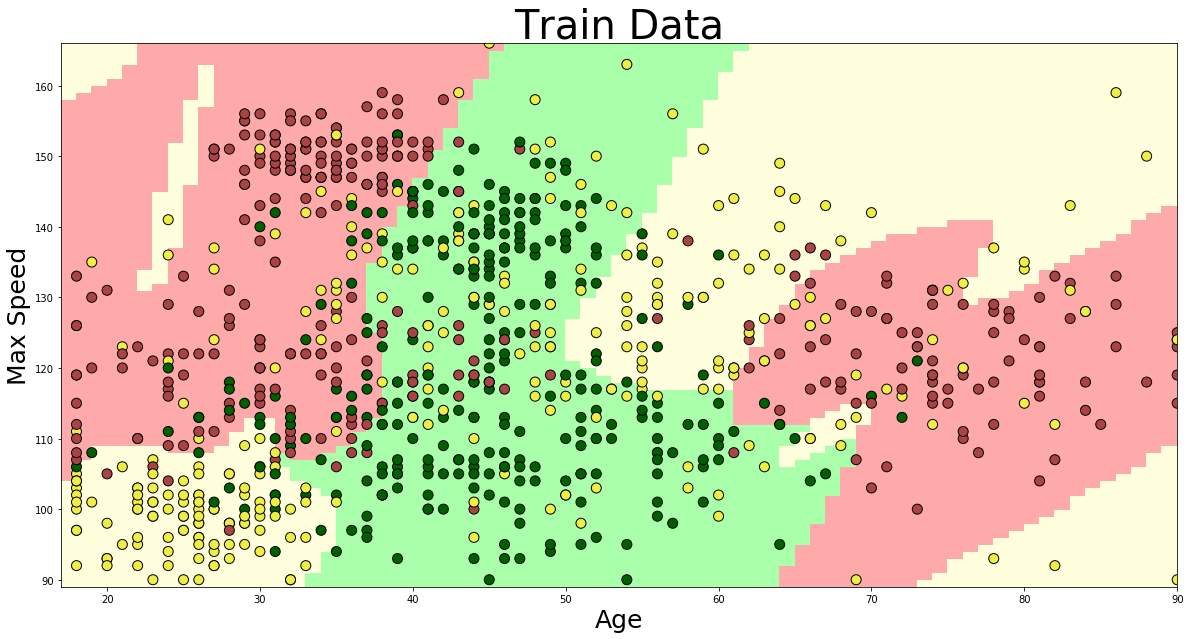

In [40]:
miles_per_year = 20
plot_prediction(model, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data")

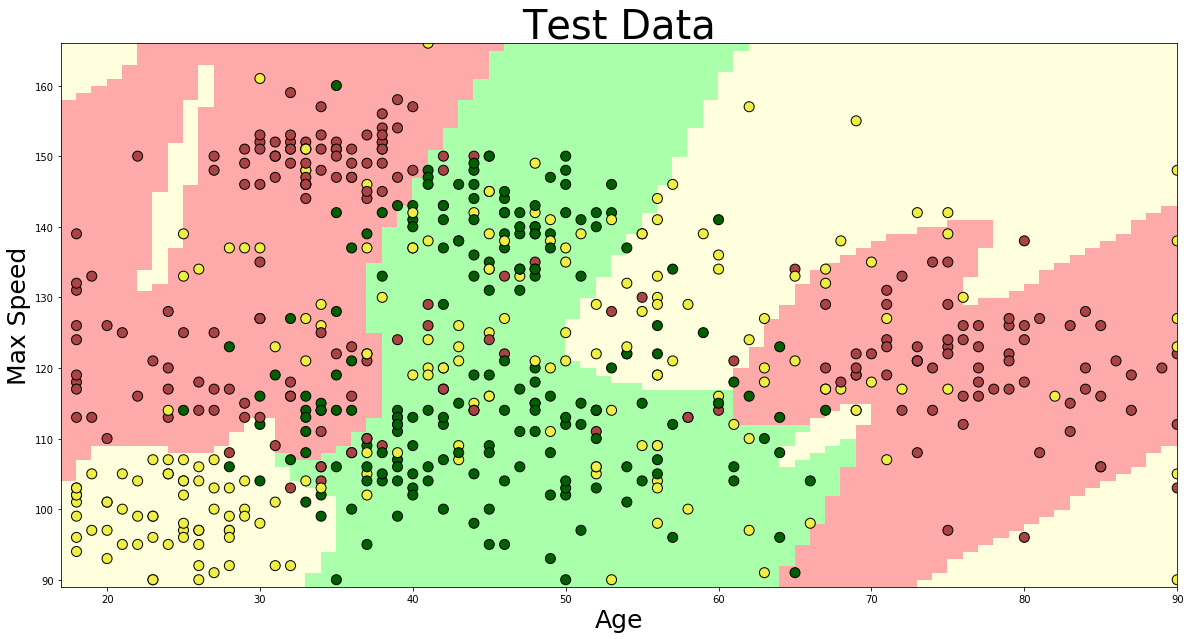

In [41]:
miles_per_year = 20
plot_prediction(model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data")

### Before we go on fixing this discrepancy between training and test data, let's make this problem a bit more realistic:
## Almost all real-life scenarios have many more than 2 inputs
* With more than 2 input features plotting decision boundaries does not make much sense any more
* From now on we work with 3 features and only rely on accuracy measures

In [ ]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(500, name='hidden1', activation='tanh', input_dim=3))
model.add(tf.keras.layers.Dense(500, name='hidden2', activation='tanh'))

model.add(tf.keras.layers.Dense(num_categories, name='classifier', activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [ ]:
BATCH_SIZE=1000
EPOCHS = 2000

!rm -rf ./tf_log
%time model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[tb_callback])

In [ ]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
train_loss, train_accuracy

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
test_loss, test_accuracy

## Third important concept: Our objective is to make the best prediction for unknown samples. This is called generalization. If we perform well on knwon data, but less good on unknown data this is called overfitting. This is to be avoided. Measures taken to avoid overfitting are also known as _regularization_.